In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

frameFiles = ['S1.jpg', 'S2.jpg', 'S3.jpg', 'S5.jpg', 'S6.jpg' ]

colorFrames = [cv2.imread(i) for i in frameFiles]
grayFrames = [cv2.cvtColor(i, cv2.COLOR_BGR2GRAY) for i in colorFrames]


In [ ]:
# cv2_imshow(colorFrames[3])
# print(len(colorFrames))

In [ ]:
orb_detector = cv2.ORB_create(3000)

kps = []
fds = []
for i in grayFrames:
    kp, fd = orb_detector.detectAndCompute(i, None)
    kps.append(kp)
    fds.append(fd)

# for i in kps:
#     print(len(i))
# print(len(kps[1]))
# print(len(fds))

In [ ]:
matchTable = np.zeros((len(fds), len(fds)))
matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck = True)

matchesTable = []

for i in range(len(fds)):
    rmatches = []
    for j in range(i+1, len(fds)):
        matches = matcher.match(fd[i], fd[j])
        matches.sort(key = lambda x: x.distance)
        matchTable[i][j] = matchTable[j][i] = len(matches)
        rmatches.append(matches)
    matchesTable.append(rmatches)


In [ ]:
print(matchTable)

[[ 0. 14. 14. 13. 15.]
 [14.  0. 16. 15. 14.]
 [14. 16.  0. 14. 12.]
 [13. 15. 14.  0. 16.]
 [15. 14. 12. 16.  0.]]


In [ ]:
matchSum = np.zeros((len(fds), 1))
for i in range(len(fds)):
    for j in range(len(fds)):
        matchSum[i] += matchTable[i][j]
print(matchSum)


[[56.]
 [59.]
 [56.]
 [58.]
 [57.]]


In [ ]:
def warpTwoImages(img1, img2, H):
    h1,w1 = img1.shape[:2]
    h2,w2 = img2.shape[:2]
    pts1 = np.float32([[0,0],[0,h1],[w1,h1],[w1,0]]).reshape(-1,1,2)
    pts2 = np.float32([[0,0],[0,h2],[w2,h2],[w2,0]]).reshape(-1,1,2)
    pts2_ = cv2.perspectiveTransform(pts2, H)
    pts = np.concatenate((pts1, pts2_), axis=0)
    [xmin, ymin] = np.int32(pts.min(axis=0).ravel() - 0.5)
    [xmax, ymax] = np.int32(pts.max(axis=0).ravel() + 0.5)
    t = [-xmin,-ymin]
    # print(pts)
    Ht = np.array([[1,0,t[0]],[0,1,t[1]],[0,0,1]]) # translate

    result = cv2.warpPerspective(img2, Ht.dot(H), (xmax-xmin, ymax-ymin))
    # print(img2)
    # im2_boundary = cv2.warpPerspective([[0,0],[0,h2],[w2,h2],[w2,0]], Ht.dot(H), (xmax-xmin, ymax-ymin))
    # print(im2_boundary)
    result[t[1]:h1+t[1],t[0]:w1+t[0]] = img1
    return result, cv2.perspectiveTransform(pts, Ht)



In [ ]:
rI = colorFrames[0]
for i in range(1, len(colorFrames)-3):  
    grI = cv2.cvtColor(rI, cv2.COLOR_BGR2GRAY)
    rIkp, rIfd = orb_detector.detectAndCompute(grI, None)
    matches = matcher.match(rIfd, fds[i])
    matches.sort(key = lambda x: x.distance)
    # matches = matches[:int(len(matches)*90)]

    dst_pts = np.float32([rIkp[m.queryIdx].pt for m in matches]).reshape(-1,1,2)
    src_pts = np.float32([kps[i][m.trainIdx].pt for m in matches]).reshape(-1,1,2)
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

    rI, pts = warpTwoImages(rI, colorFrames[i], M)


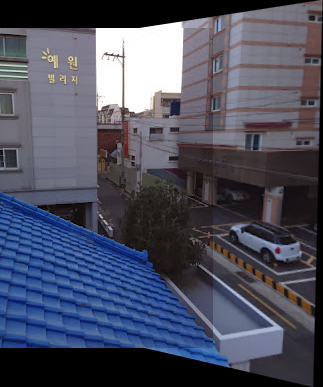

In [ ]:
cv2.imshow("ri", rI)

In [ ]:
print(pts[:4])
print(pts[4:])

[[[  0.  28.]]

 [[  0. 348.]]

 [[213. 348.]]

 [[213.  28.]]]
[[[ 8.1106300e+01  3.6804512e+01]]

 [[ 7.6110779e+01  3.3209497e+02]]

 [[ 3.1344797e+02  3.8737509e+02]]

 [[ 3.2277072e+02 -2.0966148e-01]]]


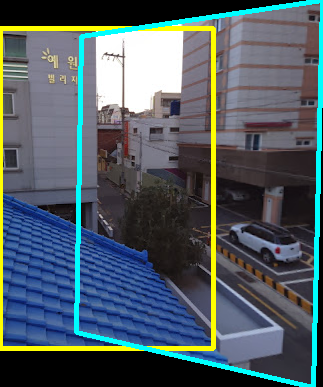

In [ ]:
pts = np.array([[pts[:]]], np.int32)
pts = pts.reshape((-1,1,2))
# img1_color = cv2.resize(img1_color, (1000,650))
cv2.polylines(rI,[pts[:4]],True,(0,255,255),3)
cv2.polylines(rI,[pts[4:]],True,(255,255,),3)
cv2.imshow("bI", rI)

In [ ]:
# dst_pts = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1,1,2)
# src_pts = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1,1,2)
# M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

# result = warpTwoImages(img1_color, img2_color, M)